In [1]:
import os
import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points

import lxml.etree as ET

import network_io as nio

from itertools import combinations

In [17]:
file_path = '../../../data/pop_1pct/paris_1pct_network.xml.gz'
districts = gpd.read_file("../../../data/visualisation/districts_paris.geojson")

base_output_links_no_policies = '../../../data/pop_1pct/output_1pct/'
base_network_no_policies = nio.read_network_data(base_output_links_no_policies)
base_network_no_policies.rename(columns={'link': 'id'}, inplace=True)


# Parse nodes and edges
nodes_dict = nio.parse_nodes(file_path)
df_edges = nio.parse_edges(file_path, nodes_dict)
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
gdf_edges_4326 = gdf_edges.to_crs(epsg=4326)

# Spatial join to find districts overlapping with each edge
gdf_edges_with_districts = gpd.sjoin(gdf_edges_4326, districts, how='left', op='intersects')

# Group by edge and aggregate the district names
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

gdf_edges_with_highway = gdf_edges_with_districts.merge(base_network_no_policies[['id', 'osm:way:highway']], on='id', how='left')
gdf_edges_with_highway.head()

31635
31635


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


31635


In [5]:
neighbouring_districts = {1: [2, 3, 4, 6, 7, 8],
                          2: [1, 3, 4, 9, 10],
                          3: [1, 2, 10, 11, 4],
                          4: [1, 3, 11, 12, 5],
                          5: [4, 12, 13, 14, 6],
                          6: [1, 5, 14, 15, 7],
                          7: [8, 1, 6,15,16],
                          8: [17, 9, 1, 7, 16],
                          9: [18, 10, 2, 8],
                          10: [3,2,9,18,19,11],
                          11: [20, 12, 4, 3, 10],
                          12:[11, 20, 13,4],
                          13: [5, 12, 14],
                          14: [5, 13, 15, 6],
                          15: [6, 14, 16, 7],
                          16: [7, 15, 17, 8],
                          17: [8, 16, 18],
                          18: [9, 17, 19, 10],
                          19: [18, 10, 20],
                          20: [11, 19, 12]}            

In [6]:
districts = list(neighbouring_districts.keys())
all_connected_subsets = []

for r in range(1, len(districts) + 1):
    for subset in combinations(districts, r):
        if nio.is_connected(set(subset), neighbouring_districts):
            all_connected_subsets.append(subset)

# Anzahl der verbundenen Teilmengen
num_connected_subsets = len(all_connected_subsets)

In [23]:
higher_order_roads = ['tertiary', 'secondary', 'primary', 'secondary_link', 'primary_link', 'tertiary_link']

In [24]:
filtered_gdf = gdf_edges_with_highway[gdf_edges_with_highway['osm:way:highway'].isin(higher_order_roads)]

In [35]:
filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry', crs='EPSG:4326')
gdf_edges_with_highway = gpd.GeoDataFrame(gdf_edges_with_highway, geometry='geometry', crs='EPSG:4326')

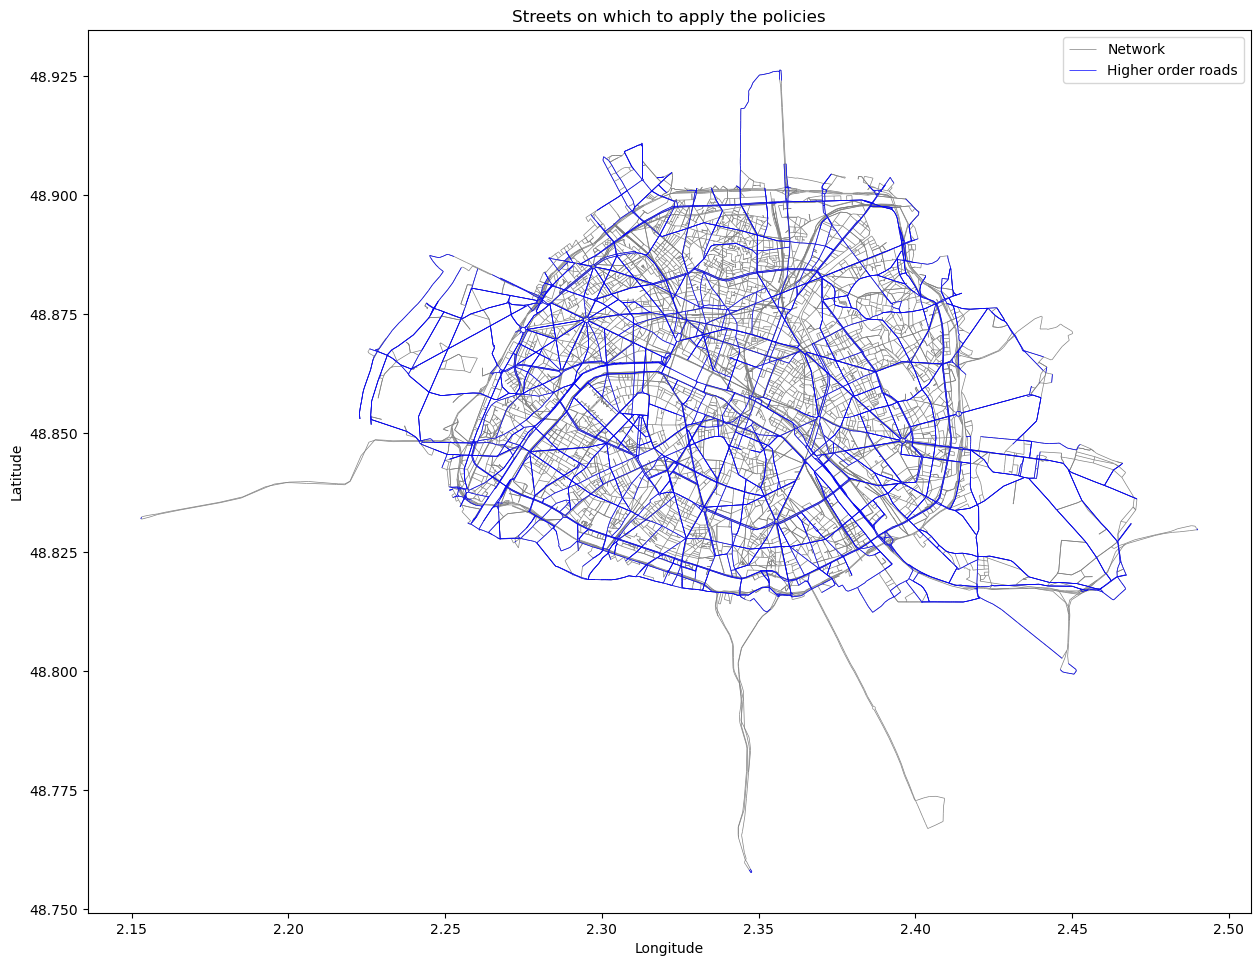

In [38]:
# Create a larger plot with thinner lines
fig, ax = plt.subplots(figsize=(15, 15))
gdf_edges_with_highway.plot(ax=ax, linewidth=0.5, color='grey', label = "Network")
filtered_gdf.plot(ax=ax, linewidth=0.5, color = "blue", label = "Higher order roads")

# Customize the plot (optional)
plt.title('Streets on which to apply the policies')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [26]:
len(filtered_gdf)/len(gdf_edges_with_highway)

0.41716453295400663

In [42]:
type(all_connected_subsets[10])

tuple

In [43]:
import random

# Ensure 'all_connected_subsets' is defined
# Randomly select 20 tuples from the list
random_subset = random.sample(all_connected_subsets, 20)

In [44]:
random_subset

[(1, 4, 7, 8, 9, 11, 12, 13, 14, 17, 18),
 (3, 4, 5, 6, 7, 9, 10, 12, 13, 17, 18),
 (2, 3, 8, 10, 11, 12, 17, 18),
 (1, 4, 5, 7, 9, 10, 13, 14, 16, 17, 18),
 (1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 18, 19),
 (1, 2, 4, 5, 6, 9, 10, 12, 16, 17, 18, 19, 20),
 (1, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 17, 19),
 (1, 2, 3, 4, 8, 10, 11, 12, 13, 16, 19, 20),
 (4, 6, 7, 8, 9, 10, 11, 12, 13, 18),
 (1, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20),
 (1, 4, 5, 6, 11, 17, 18, 19, 20),
 (2, 4, 5, 6, 8, 9, 11, 13, 15, 16),
 (1, 2, 3, 5, 6, 7, 8, 9, 13, 15),
 (1, 2, 3, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20),
 (1, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 20),
 (4, 5, 6, 7, 10, 11, 12, 16, 17, 18),
 (1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18, 19, 20),
 (1, 3, 4, 5, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20),
 (1, 3, 6, 7, 10, 11, 12, 13, 16, 18),
 (1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 17, 20)]

In [50]:
# Save the random_subset list to a file using pickle
with open('subset_06_06.pkl', 'wb') as file:
    pickle.dump(random_subset, file)

In [45]:
dataframes = []
for combination in random_subset:
    df_copy = gdf_edges_with_highway.copy()
    df_copy['policy_introduced'] = df_copy.apply(
        lambda row: 'car' in row['modes'] and any(d in row['district'] for d in combination) and row['osm:way:highway'] in higher_order_roads,
        axis=1
    )    
    # Modify freespeed and capacity based on the policy_introduced condition
    df_copy.loc[df_copy['policy_introduced'], 'capacity'] = df_copy.loc[df_copy['policy_introduced'], 'capacity'] / 2
    dataframes.append(df_copy)

In [47]:
len(dataframes)

20

In [49]:
# Directory to save the files
output_dir = '../../../data/pop_1pct_with_policies/networks/'
os.makedirs(output_dir, exist_ok=True)

# Create and save the networks
for i, df in enumerate(dataframes):
    # Determine the filename based on the combination
    combination = random_subset[i]
    if len(combination) == 1:
        filename = f"network_d_{combination[0]}.xml.gz"
    else:
        filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
    # Convert the DataFrame back to XML
    xml_tree = nio.dataframe_to_xml(df, nodes_dict)
    
    # Write the XML to a compressed .gz file
    file_path = os.path.join(output_dir, filename)
    nio.write_xml_to_gz(xml_tree, file_path)

# Example: Display the file paths of the saved files
output_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)]

(1, 4, 7, 8, 9, 11, 12, 13, 14, 17, 18)
(3, 4, 5, 6, 7, 9, 10, 12, 13, 17, 18)
(2, 3, 8, 10, 11, 12, 17, 18)
(1, 4, 5, 7, 9, 10, 13, 14, 16, 17, 18)
(1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 18, 19)
(1, 2, 4, 5, 6, 9, 10, 12, 16, 17, 18, 19, 20)
(1, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 17, 19)
(1, 2, 3, 4, 8, 10, 11, 12, 13, 16, 19, 20)
(4, 6, 7, 8, 9, 10, 11, 12, 13, 18)
(1, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20)
(1, 4, 5, 6, 11, 17, 18, 19, 20)
(2, 4, 5, 6, 8, 9, 11, 13, 15, 16)
(1, 2, 3, 5, 6, 7, 8, 9, 13, 15)
(1, 2, 3, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20)
(1, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 20)
(4, 5, 6, 7, 10, 11, 12, 16, 17, 18)
(1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18, 19, 20)
(1, 3, 4, 5, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20)
(1, 3, 6, 7, 10, 11, 12, 13, 16, 18)
(1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 17, 20)
